## Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Virtual memory usage - total: 126 GB / available: 96 GB / percent used: 23.1 %


# Relief.nc 
From Jean-Zay: /gpfswork/rech/psl/commun/IGCM/ATM/INPUT_CE0L

In [7]:
np.pi

3.141592653589793

In [ ]:
np.deg2rad

In [ ]:
np.deg

In [36]:
def deg2km(nlon, nlat, lat):
    # Gives the size of a grid cell in km at the corresponding latitude
    R_earth = 6371
    x = 2*np.pi*R_earth/nlon*np.cos(np.deg2rad(lat))
    y = np.pi*R_earth/nlat
    return {'x': x, 'y': y, 'units': 'km'}

In [37]:
deg2km(nlon=360, nlat=180, lat=30)

{'x': 96.29763124613503, 'y': 111.19492664455873, 'units': 'km'}

In [3]:
xr.open_dataset('/home/mlalande/notebooks/Relief.nc').RELIEF

<xarray.DataArray 'RELIEF' (latitude: 1080, longitude: 2160)>
[2332800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.9167 -179.75 ... 179.75 179.9167
  * latitude   (latitude) float32 89.91655 89.74982 ... -89.74982 -89.91655
Attributes:
    units:     m
    title:     RELIEF
    lon_name:  RELIEF

In [37]:
deg2km(nlon=360, nlat=180, lat=30)

{'x': 96.29763124613503, 'y': 111.19492664455873, 'units': 'km'}

## Load model data

In [2]:
# Define period
period = slice('1981','2014')

In the next cells the `chunks={'time': 120}` allows not to load full data set but take it by chunks of 10 years. This allows to parallelize the computation and/or make fit into the memory (see **xarray/dask**: http://xarray.pydata.org/en/stable/dask.html)

In [3]:
# Load historical
snc_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

# Load amip
snc_amip = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/amip/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

# Load land-hist
snc_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/IPSL/IPSL-CM6A-LR/land-hist/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc

In [4]:
# Load HighResMIP
snc_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/LImon/snc/gr/latest/*.nc', combine='by_coords'
).sel(time=period).snc
snc_HR

<xarray.DataArray 'snc' (time: 408, lat: 361, lon: 512)>
dask.array<getitem, shape=(408, 361, 512), dtype=float32, chunksize=(408, 361, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 0.0 0.703125 1.40625 ... 358.59375 359.29688
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

## Load Rutger University data set

In [5]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)

### Get the snc variable, keep only land data, convert to % and resample by months
Resampling with xarray: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html  
**Offset aliases**: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases  
Here we use: **MS**	month start frequency

In [6]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    snc_rutger = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
snc_rutger.attrs['units'] = '%'

# Rename lon and lat for the regrid
snc_rutger = snc_rutger.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
snc_rutger = snc_rutger.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)
snc_rutger

/home/mlalande/miniconda3/lib/python3.7/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/home/mlalande/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'snow_cover_extent' (time: 408, rows: 88, cols: 88)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-01 ... 2014-12-01
    snow_cover_threshold  float32 0.42
    lat                   (rows, cols) float64 0.6592 1.322 ... 1.322 0.6592
    lon                   (rows, cols) float64 145.0 144.3 ... -35.67 -35.0
Dimensions without coordinates: rows, cols
Attributes:
    long_name:      NOAA/NCDC Climate Data Record of snow cover extent
    standard_name:  surface_snow_binary_mask
    grid_mapping:   coord_system
    valid_range:    [0 1]
    flag_values:    [0 1]
    flag_meanings:  no_snow snow_covered
    units:          %

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/)
Value of cells in the new grid that are outside the old grid's domain #15 (https://github.com/JiaweiZhuang/xESMF/issues/15)

In [7]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder = xe.Regridder(snc_rutger, snc_historical, 'bilinear', periodic=False)
regridder = add_matrix_NaNs(regridder)
print(regridder)

# Regrid the data
snc_rutger_regrid = regridder(snc_rutger)

Overwrite existing file: bilinear_88x88_143x144.nc 
 You can set reuse_weights=True to save computing time.


/home/mlalande/miniconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? False 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

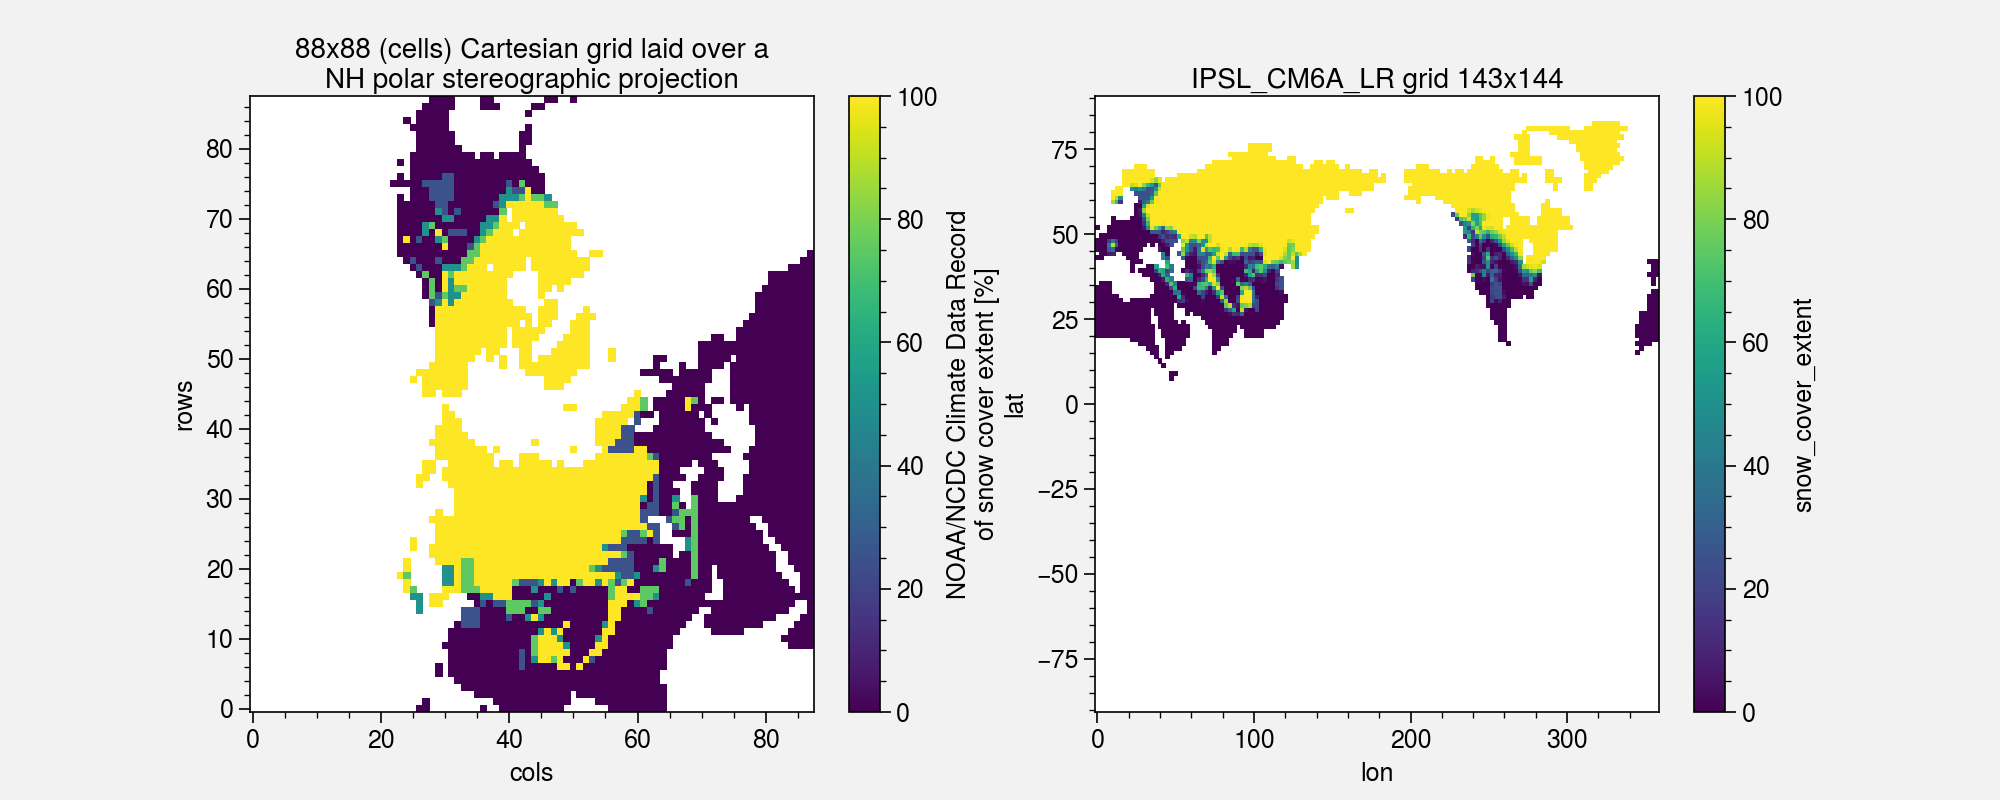

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(121)
snc_rutger[0].plot()
plt.title('88x88 (cells) Cartesian grid laid over a\nNH polar stereographic projection')
plt.subplot(122)
snc_rutger_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

In [9]:
# Regrid HighResMIP
regridder = xe.Regridder(snc_HR, snc_historical, 'bilinear', periodic=True)
regridder

Overwrite existing file: bilinear_361x512_143x144_peri.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [10]:
# Regrid the data
snc_HR_regrid = regridder(snc_HR)

## Climatology

In [11]:
snc_historical_clim = u.clim(snc_historical)
snc_historical_clim.load()

snc_amip_clim = u.clim(snc_amip)
snc_amip_clim.load()

snc_land_hist_clim = u.clim(snc_land_hist)
snc_land_hist_clim.load()

snc_rutger_regrid_clim = u.clim(snc_rutger_regrid)
snc_rutger_regrid_clim.load()

snc_HR_regrid_clim = u.clim(snc_HR_regrid)
snc_HR_regrid_clim.load()

<xarray.DataArray (lat: 143, lon: 144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
Attributes:
    regrid_method:  bilinear

In [25]:
latlim=(10,50)
lonlim=(60,110)

bias = xr.concat(
    [
        snc_historical_clim-snc_rutger_regrid_clim,
        snc_amip_clim-snc_rutger_regrid_clim,
        snc_land_hist_clim-snc_rutger_regrid_clim,
        snc_HR_regrid_clim-snc_rutger_regrid_clim
    ],
    pd.Index(
        [
            'Historical (143x144) - NOAA CDR (88x88 NH)',
            'AMIP (143x144) - NOAA CDR (88x88 NH)',
            'land-hist (143x144) - NOAA CDR (88x88 NH)',
            'HR (361x512) - NOAA CDR (88x88 NH)'
        ], 
        name='bias'
    )
).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

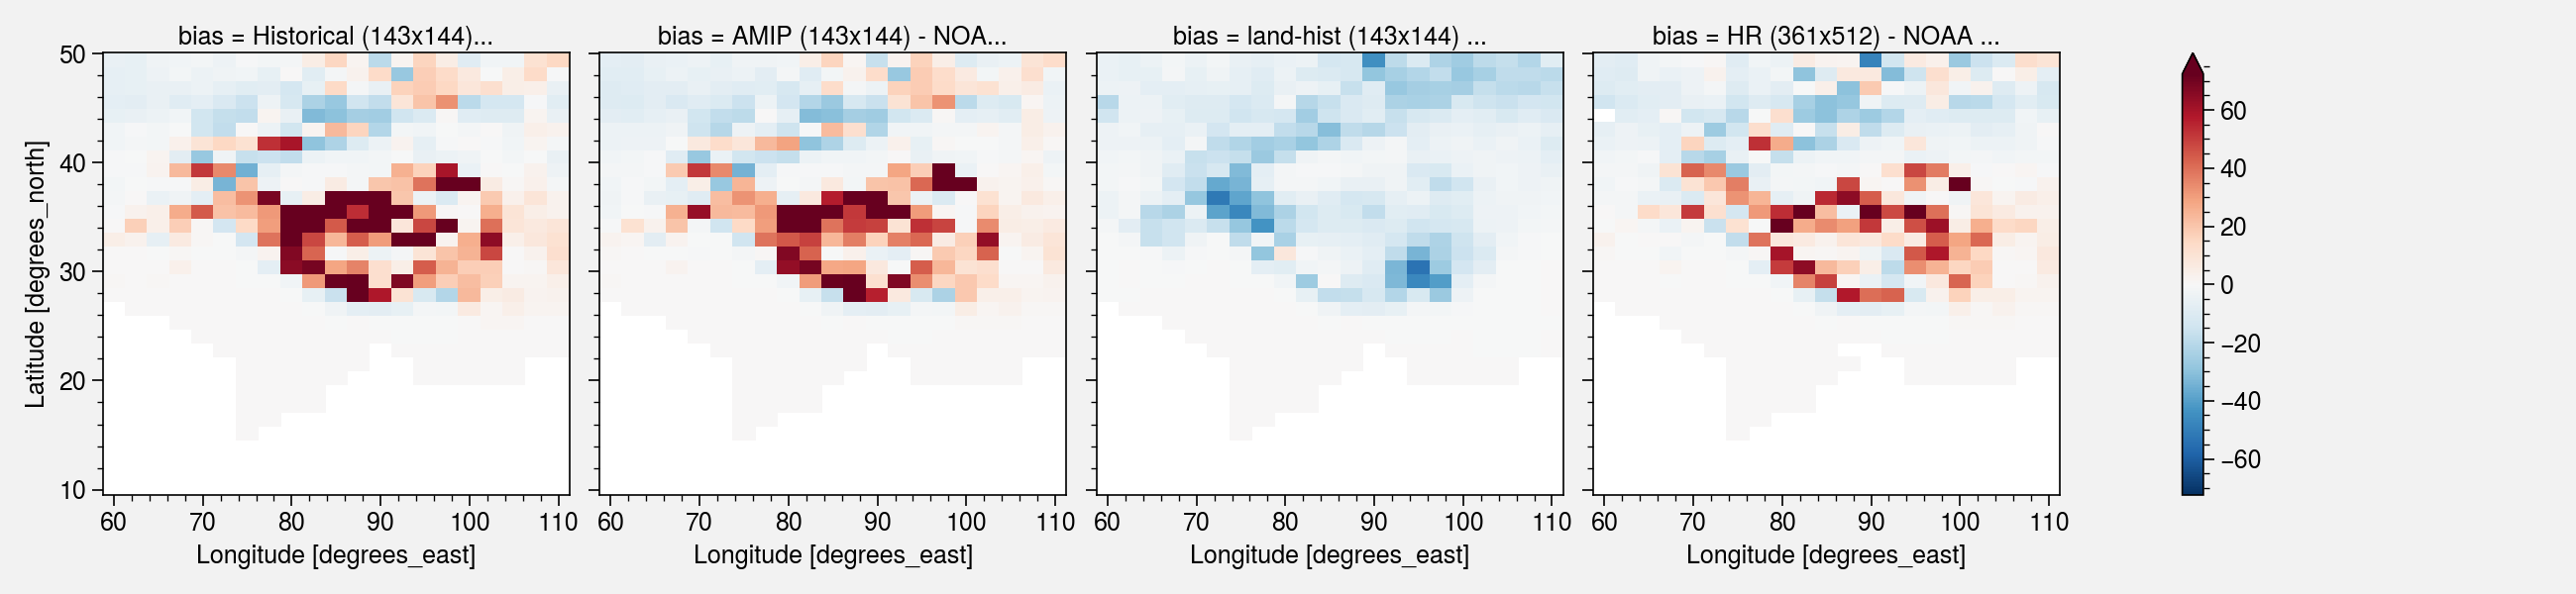

In [26]:
bias.plot(col='bias', robust=True)

In [14]:
bias.max()

<xarray.DataArray ()>
array(90.76925091)
Coordinates:
    snow_cover_threshold  float32 0.42

In [15]:
bias.min()

<xarray.DataArray ()>
array(-53.33603593)
Coordinates:
    snow_cover_threshold  float32 0.42

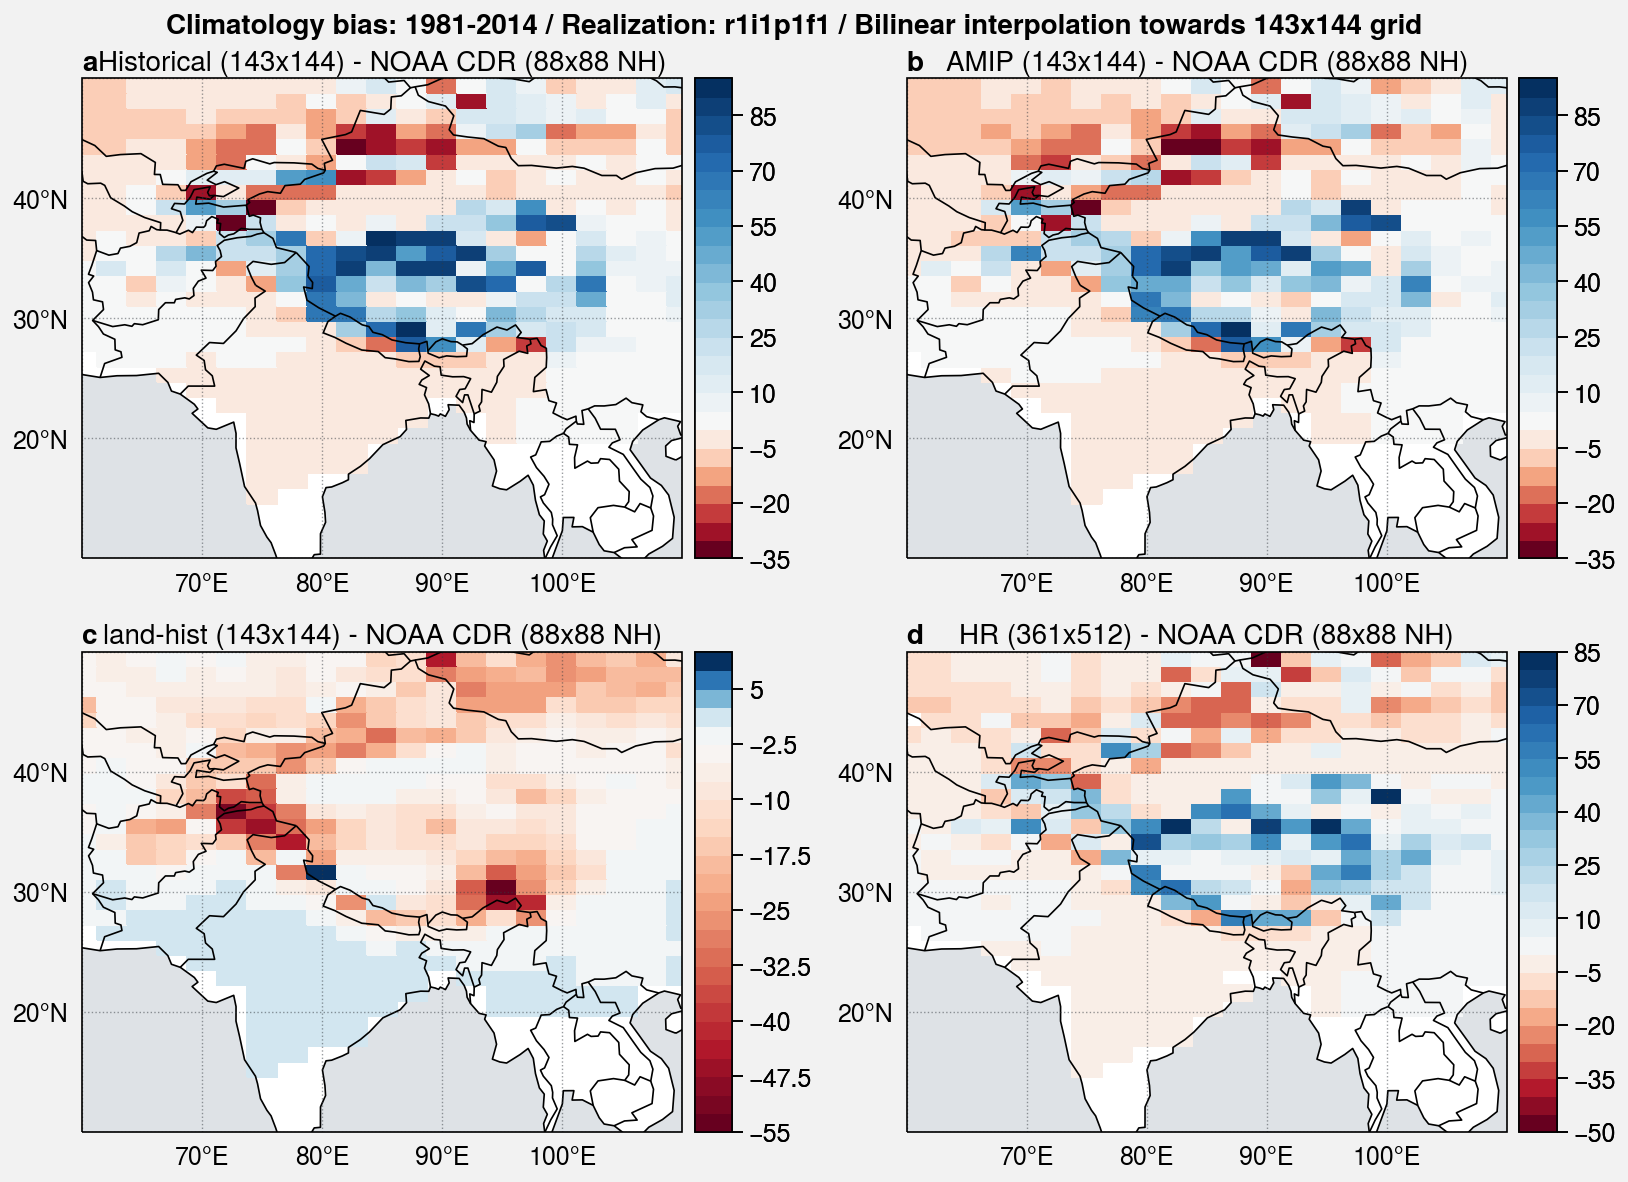

In [32]:
# Check colorbars extent

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu',  
        colorbar='r',
        norm='midpoint',
        levels=30
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

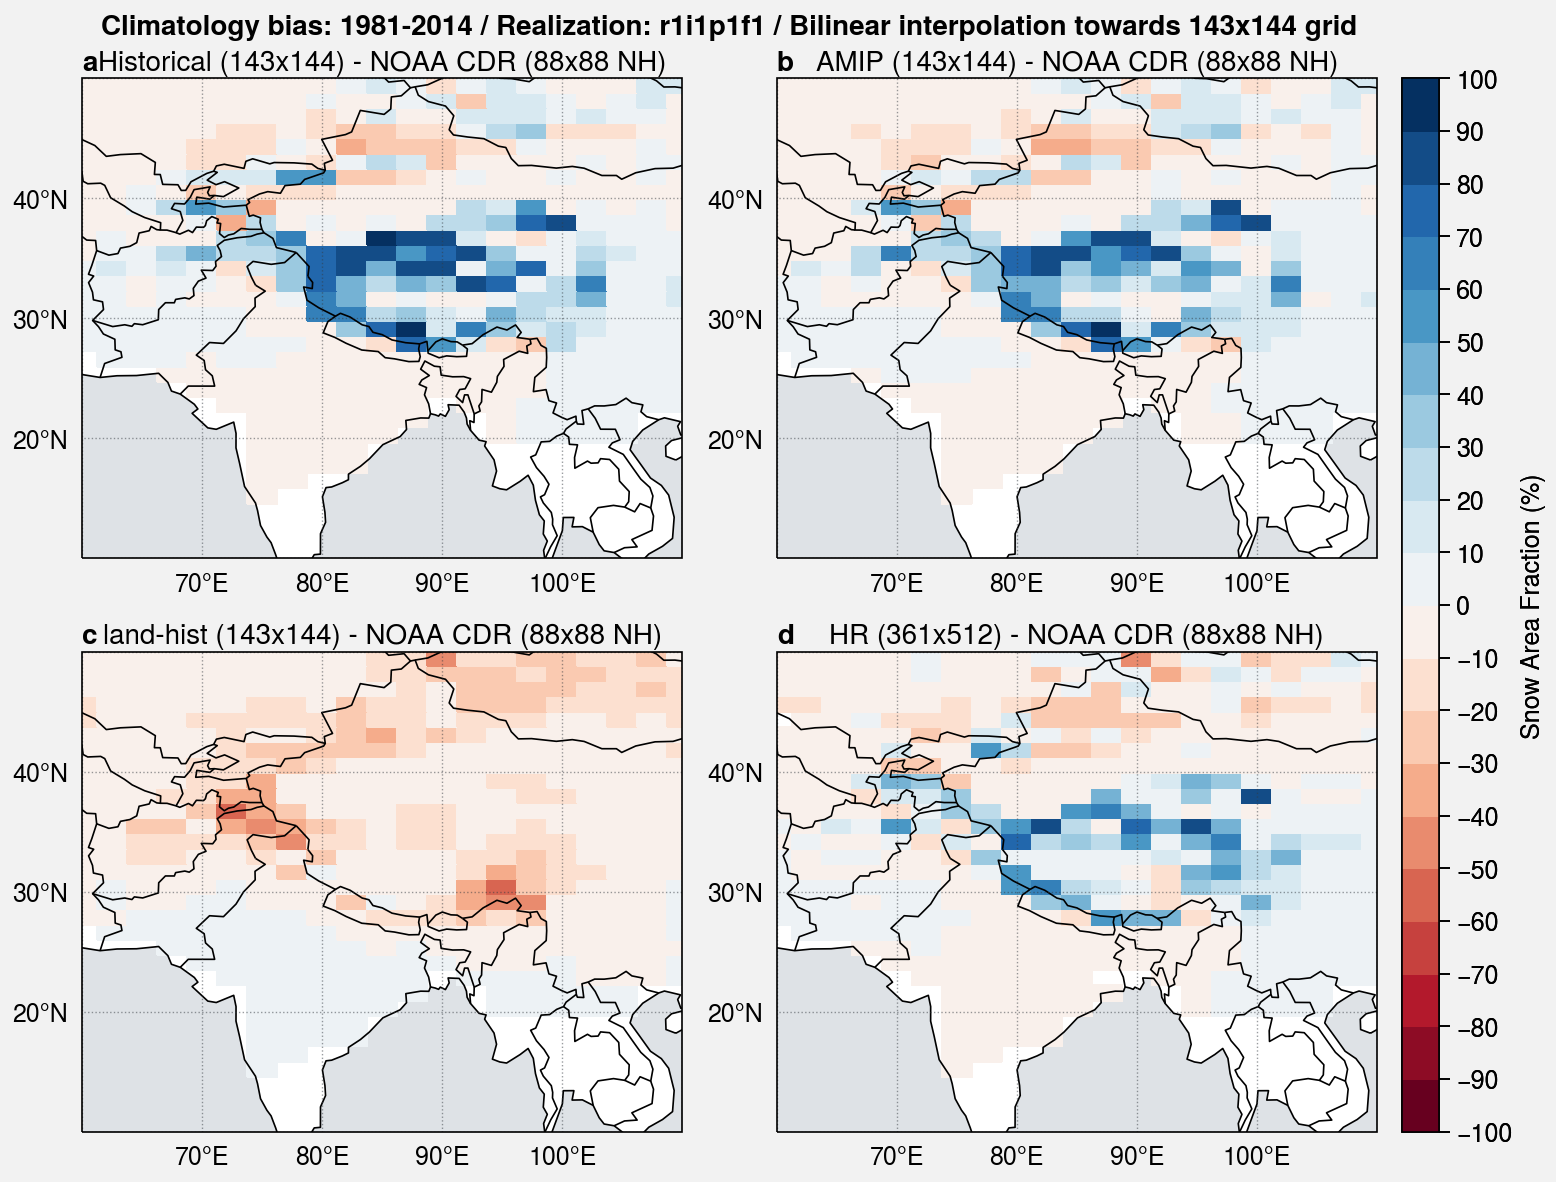

In [33]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu', 
        levels=plot.arange(-100,100,10), 
    #     extend='both',
#         norm='midpoint'
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/snow_cover_IPSL_CMIP6_bias.pdf')

# Check orography

In [34]:
orog = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
)

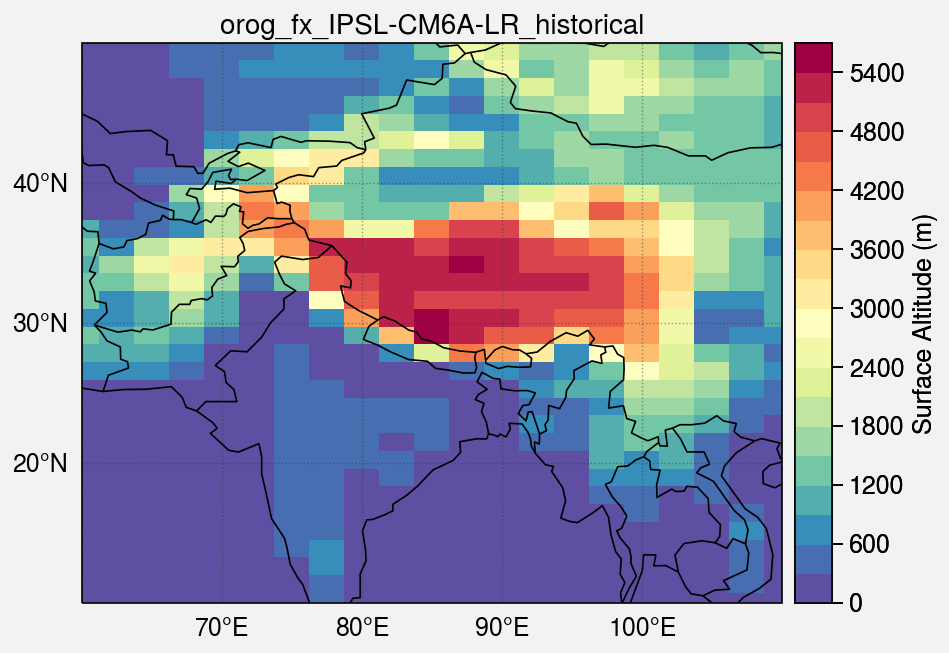

In [36]:
# Differences from Rutger
f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, share=3, axwidth=3.5)

m = axs[0].pcolormesh(
    orog.sel(lat=slice(10,50), lon=slice(60,110)),
    colorbar='r',
    levels=20,
    cmap='Spectral'
)
axs[0].format(title='orog_fx_IPSL-CM6A-LR_historical')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    lonlines=10, latlines=10, latlim=(10,50), lonlim=(60,110)
)

# f.save('img/orog.pdf')

# Annual cycle on the bias zone

Rectangle:  
- https://matplotlib.org/gallery/pyplots/text_layout.html#sphx-glr-gallery-pyplots-text-layout-py  
- https://scitools.org.uk/cartopy/docs/v0.5/matplotlib/introductory_examples/02.polygon.html

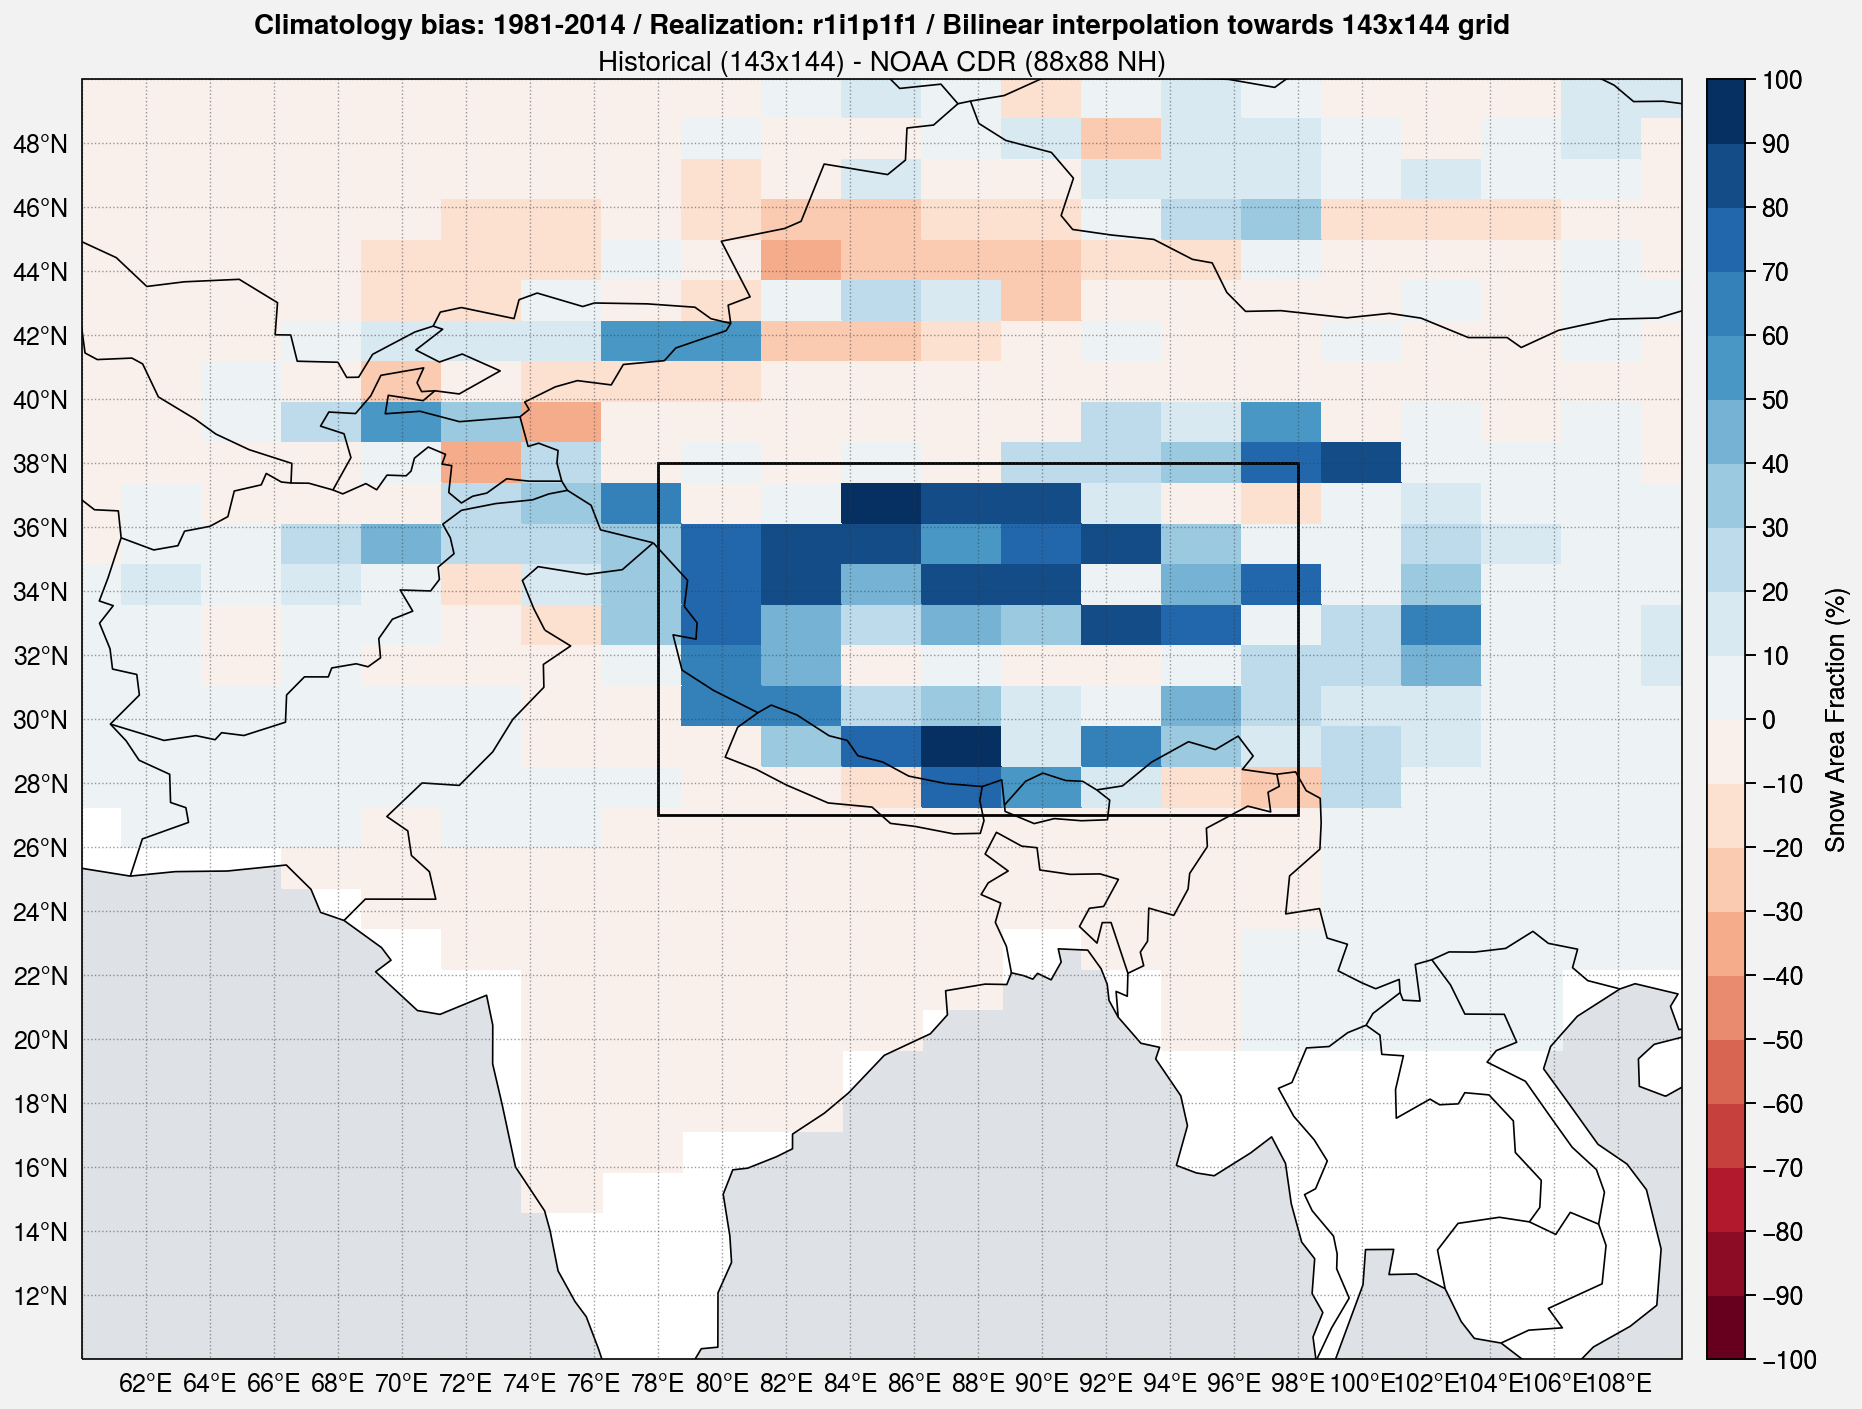

In [37]:
# Zone

import matplotlib.patches as mpatches
import cartopy.crs as ccrs

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, share=3, axwidth=8)

i=0

m = axs.pcolormesh(
    bias.isel(bias=i), 
    cmap='RdBu', 
    levels=plot.arange(-100,100,10), 
#     extend='both',
#         norm='midpoint'
)
axs.format(title=str(bias.isel(bias=i).bias.values))

axs.add_patch(
    mpatches.Rectangle(
        xy=[78, 27], width=20, height=11,
#         facecolor='blue',
#         alpha=0.2,
        transform=ccrs.PlateCarree(),
        fill=False
    )
)

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Climatology bias: 1981-2014 / Realization: r1i1p1f1 / Bilinear interpolation towards 143x144 grid",
    lonlines=2, latlines=2, latlim=latlim, lonlim=lonlim
)

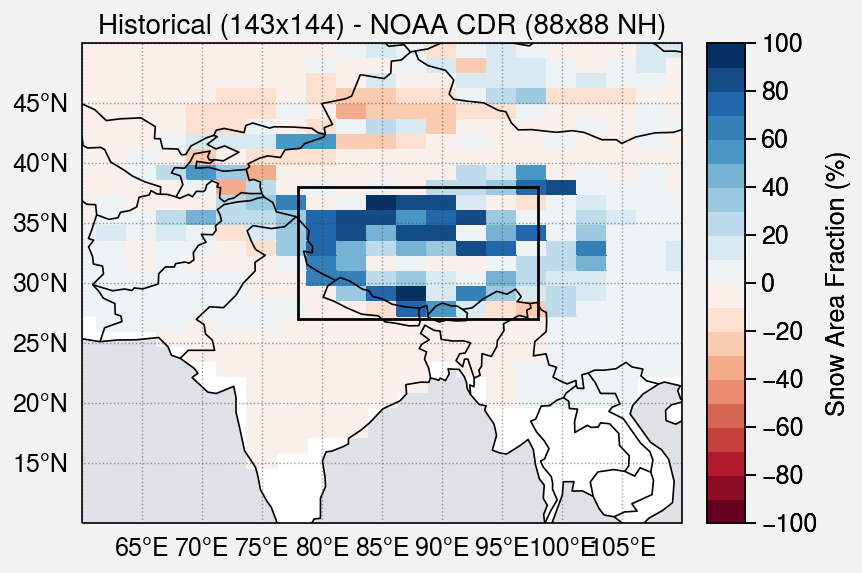

In [40]:
# Zone

import matplotlib.patches as mpatches
import cartopy.crs as ccrs

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, share=3, axwidth=3)

i=0

m = axs.pcolormesh(
    bias.isel(bias=i), 
    cmap='RdBu', 
    levels=plot.arange(-100,100,10), 
#     extend='both',
#         norm='midpoint'
)
axs.format(title=str(bias.isel(bias=i).bias.values))

axs.add_patch(
    mpatches.Rectangle(
        xy=[78, 27], width=20, height=11,
#         facecolor='blue',
#         alpha=0.2,
        transform=ccrs.PlateCarree(),
        fill=False
    )
)

f.colorbar(m, label='Snow Area Fraction (%)')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    lonlines=5, latlines=5, latlim=latlim, lonlim=lonlim
)

# f.save('img/ac_zone.pdf')

xy=[78, 27], width=20, height=11,

In [41]:
lonlim_zone=(78,78+20)
latlim_zone=(27,27+11)

In [42]:
test = snc_historical.sel(
        lon=slice(lonlim_zone[0],lonlim_zone[1]), 
        lat=slice(latlim_zone[0],latlim_zone[1])
    )

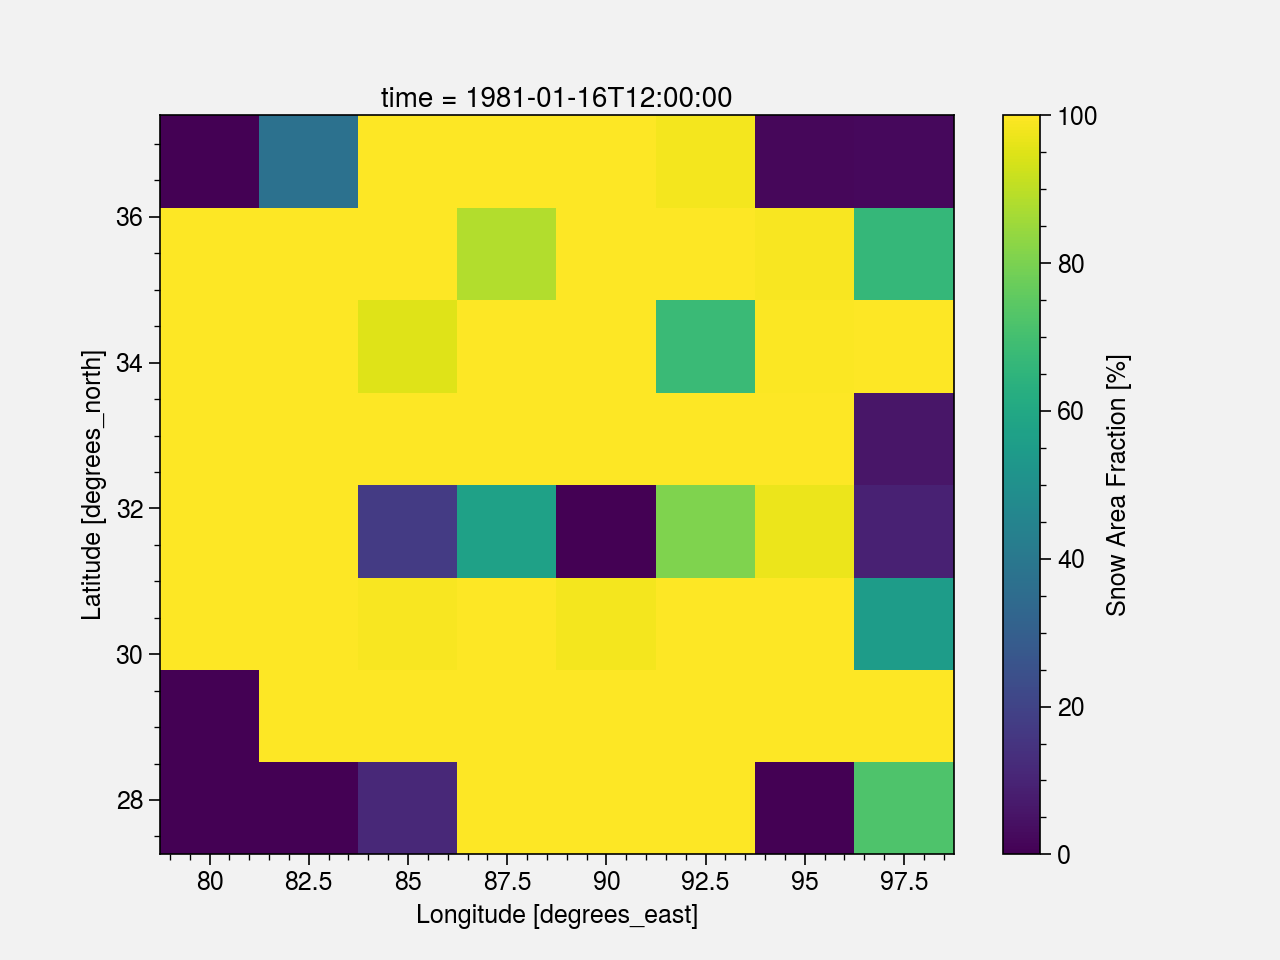

In [43]:
test[0].plot()

In [44]:
(u.spatial_average(
    snc_historical[0].sel(
        lon=slice(lonlim_zone[0],lonlim_zone[1]), 
        lat=slice(latlim_zone[0],latlim_zone[1])
    )
)).values

array(77.36092, dtype=float32)

In [45]:
# Compute annual cycles on the zone
ac_historical = u.annual_cycle(u.spatial_average(
    snc_historical.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))
)).load()
ac_amip = u.annual_cycle(u.spatial_average(
    snc_amip.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))
)).load()
ac_land_hist = u.annual_cycle(u.spatial_average(
    snc_land_hist.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))
)).load()
ac_rutger_regrid = u.annual_cycle(u.spatial_average(
    snc_rutger_regrid.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))
)).load()
ac_HR_regrid = u.annual_cycle(u.spatial_average(
    snc_HR_regrid.sel(lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1]))
)).load()

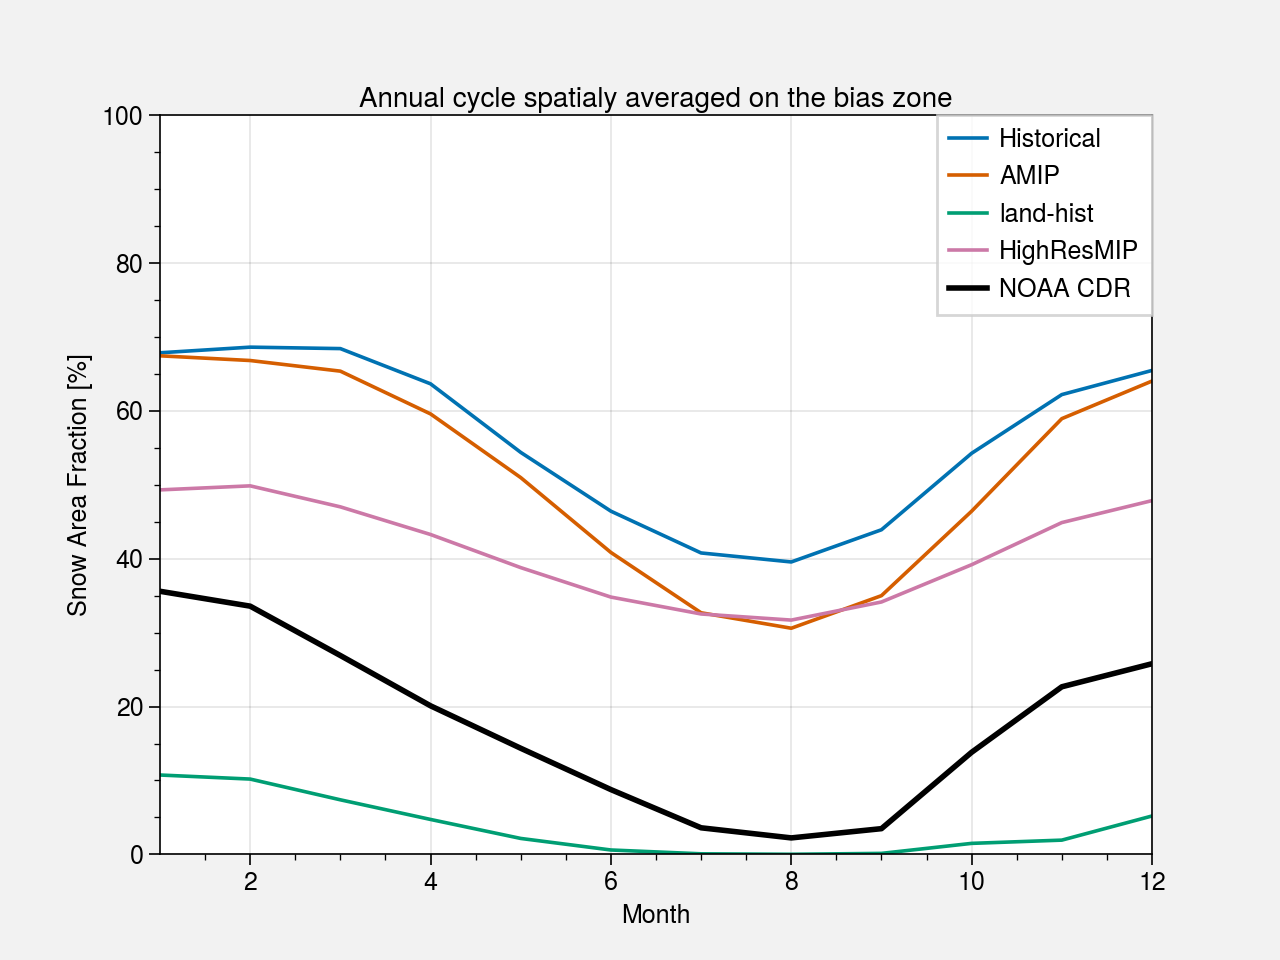

In [47]:
plt.figure()

ac_historical.plot(label='Historical')
ac_amip.plot(label='AMIP')
ac_land_hist.plot(label='land-hist')
ac_HR_regrid.plot(label='HighResMIP')

ac_rutger_regrid.plot(label='NOAA CDR', color='black', linewidth=2)

plt.title('Annual cycle spatialy averaged on the bias zone')
plt.ylim(0,100)
plt.ylabel('Snow Area Fraction [%]')
plt.xlabel('Month')
plt.legend()

# plt.savefig('img/ac_snow_cover_IPSL_CMIP6.pdf')

Check snow cover from:
https://climate.rutgers.edu/snowcover/chart_clim.php?ui_month=1

# Check ensemble dispersion for historical

In [11]:
snc_historical_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/*/LImon/snc/gr/latest/*.nc', combine='nested', concat_dim='realization', parallel=True
).sel(time=period, lon=slice(lonlim_zone[0],lonlim_zone[1]), lat=slice(latlim_zone[0],latlim_zone[1])).snc
snc_historical_ens

<xarray.DataArray 'snc' (realization: 32, time: 408, lat: 8, lon: 8)>
dask.array<getitem, shape=(32, 408, 8, 8), dtype=float32, chunksize=(1, 408, 8, 8), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float32 27.887323 29.15493 30.422535 ... 35.492958 36.760563
  * lon      (lon) float32 80.0 82.5 85.0 87.5 90.0 92.5 95.0 97.5
Dimensions without coordinates: realization
Attributes:
    long_name:           Snow Area Fraction
    units:               %
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       surface_snow_area_fraction
    description:         Fraction of each grid cell that is occupied by snow ...
    history:             none
    cell_measures:       area: areacella

In [13]:
ac_historical_ens = u.annual_cycle(u.spatial_average(snc_historical_ens)).load()
ac_historical_ens

<xarray.DataArray (realization: 32, month: 12)>
array([[69.12983199, 68.57001238, 66.81959612, 62.92657998, 54.34280833,
        46.43518257, 40.84296642, 39.57193621, 44.24168351, 54.07966053,
        62.92519143, 66.49350873],
       [70.27313232, 69.21337157, 67.54458944, 62.65725629, 54.39249431,
        46.35065887, 40.45902869, 39.5604045 , 43.36200366, 54.13660173,
        63.76274277, 68.58834839],
       [67.3559052 , 67.93470445, 67.37660722, 62.45253148, 54.60552092,
        46.31258269, 40.87196866, 39.36166124, 43.89990795, 52.52727778,
        62.77440733, 65.33582934],
       [68.27663354, 68.56252824, 67.37497812, 62.08764155, 53.23148974,
        45.86466307, 40.50582706, 38.96097464, 44.07821016, 56.29394419,
        63.72873531, 67.30468716],
       [68.79889713, 68.2343173 , 66.7509613 , 61.2851273 , 53.33952657,
        46.18845827, 40.76941681, 39.86198941, 43.92713233, 53.64920807,
        62.12824092, 65.8868857 ],
       [69.33226698, 69.24588172, 67.8315184 , 63.28285666, 54.67041655,
        46.68283934, 41.03337815, 39.63665603, 44.39493325, 53.9250136 ,
        63.35168423, 67.63540358],
       [69.87211441, 69.75132268, 67.92370976, 63.89126104, 56.27660179,
        47.1747027 , 41.33093217, 40.41817732, 44.73846525, 54.98130854,
        64.50913575, 68.11408548],
       [70.08745407, 68.82485429, 68.27429715, 63.13738475, 55.52086774,
        47.07965357, 41.18988463, 39.83068365, 44.75987143, 56.81346646,
        65.73053674, 68.90736602],
       [70.06344178, 69.14319846, 67.55412775, 62.88002755, 54.81758712,
        46.32444606, 40.93664786, 40.09523448, 44.77009302, 54.93891615,
        63.18499666, 68.41081081],
       [70.36934942, 69.56624293, 67.85438683, 61.8950036 , 54.45871376,
        46.40504276, 41.05290402, 39.01435033, 44.54184139, 54.71401439,
        65.42870645, 69.55272921],
       [67.85893732, 68.62141449, 68.42540281, 63.65927393, 54.38420621,
        46.43134297, 40.77954977, 39.56204661, 43.91719538, 54.26346768,
        62.2044956 , 65.47090901],
       [67.38610279, 67.64280657, 66.79191017, 62.4608556 , 53.84651521,
        45.6910774 , 40.47228824, 39.22858451, 43.94317077, 54.18055456,
        60.77600861, 65.18420635],
       [68.40911977, 67.48336523, 65.68642325, 61.81706687, 54.77068912,
        46.92864014, 41.78012006, 40.29406514, 44.55787771, 52.84994148,
        62.35178185, 66.64231177],
       [69.29328256, 68.31405461, 66.90297093, 62.00714953, 54.44366522,
        46.90107144, 40.97570307, 40.07677763, 44.80856772, 52.86302084,
        62.35351349, 66.68676803],
       [68.55945733, 68.55126429, 67.60168479, 62.3248245 , 54.74459143,
        46.31466495, 40.64736445, 39.74781014, 45.23067553, 56.48114687,
        65.29760103, 68.15787562],
       [70.55654997, 69.9586026 , 68.48080422, 63.38460664, 54.03820756,
        45.64094768, 41.07163631, 39.48735944, 43.93286593, 54.40852625,
        64.84160322, 68.11966548],
       [69.00769963, 68.96364727, 67.71952562, 62.55368233, 54.97407072,
        47.14212047, 41.37207895, 39.63848978, 43.35094014, 54.18710821,
        64.56034414, 67.62129795],
       [68.42548168, 67.84332707, 66.73442201, 61.78395036, 53.77250716,
        46.19810172, 40.63358778, 38.94254673, 44.43571932, 53.55643127,
        64.54035097, 67.22252195],
       [66.67488973, 68.14498551, 66.96788844, 62.47447373, 55.75869078,
        46.60504857, 41.34014275, 39.87161255, 44.39254346, 53.01374851,
        61.80814283, 65.45317986],
       [68.2947243 , 68.12835517, 66.99866744, 61.64861152, 54.30529819,
        46.6360753 , 40.85099781, 39.62487097, 44.13424873, 53.61638462,
        63.67731801, 66.47209325],
       [69.01280628, 68.80785316, 66.59075726, 61.60636139, 53.82318755,
        46.15397206, 40.27518306, 39.24139101, 43.31399626, 52.68382936,
        62.47986378, 66.29582663],
       [69.58908564, 69.60374   , 67.43928146, 62.58886898, 55.57951198,
        46.94728683, 41.34343933, 40.13871372, 44.65921267, 54.67115683,
     

In [28]:
x = ac_historical_ens.month
y = ac_historical_ens.mean('realization')
std = ac_historical_ens.std('realization')

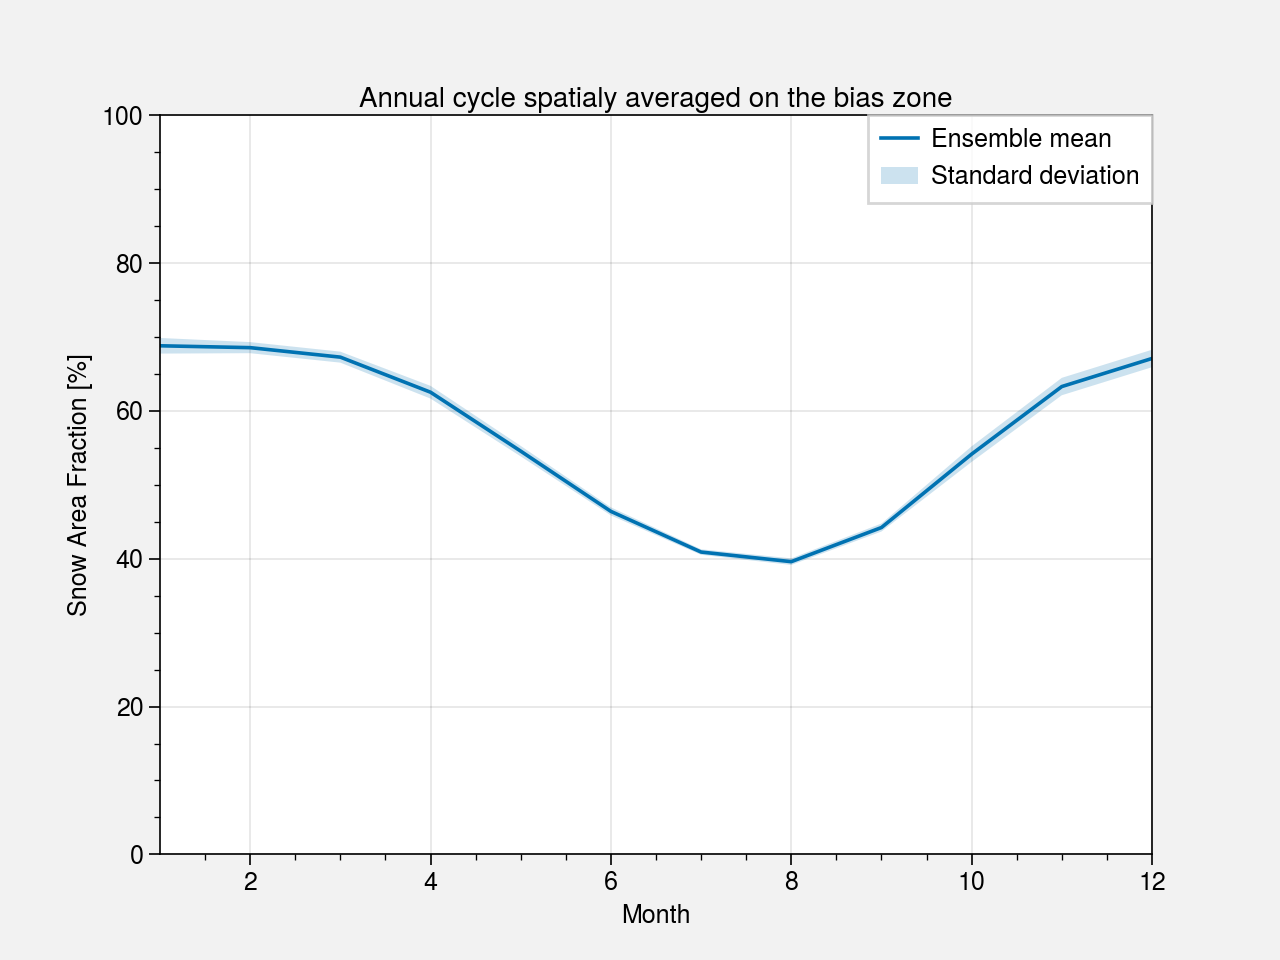

In [30]:
fig, ax = plt.subplots()

y.plot(ax=ax, label='Ensemble mean')
ax.fill_between(x, y-std, y+std, alpha=0.2, label='Standard deviation')

plt.title('Annual cycle spatialy averaged on the bias zone')
plt.ylim(0,100)
plt.ylabel('Snow Area Fraction [%]')
plt.xlabel('Month')
plt.legend()

Text(0.5, 0, 'Month')

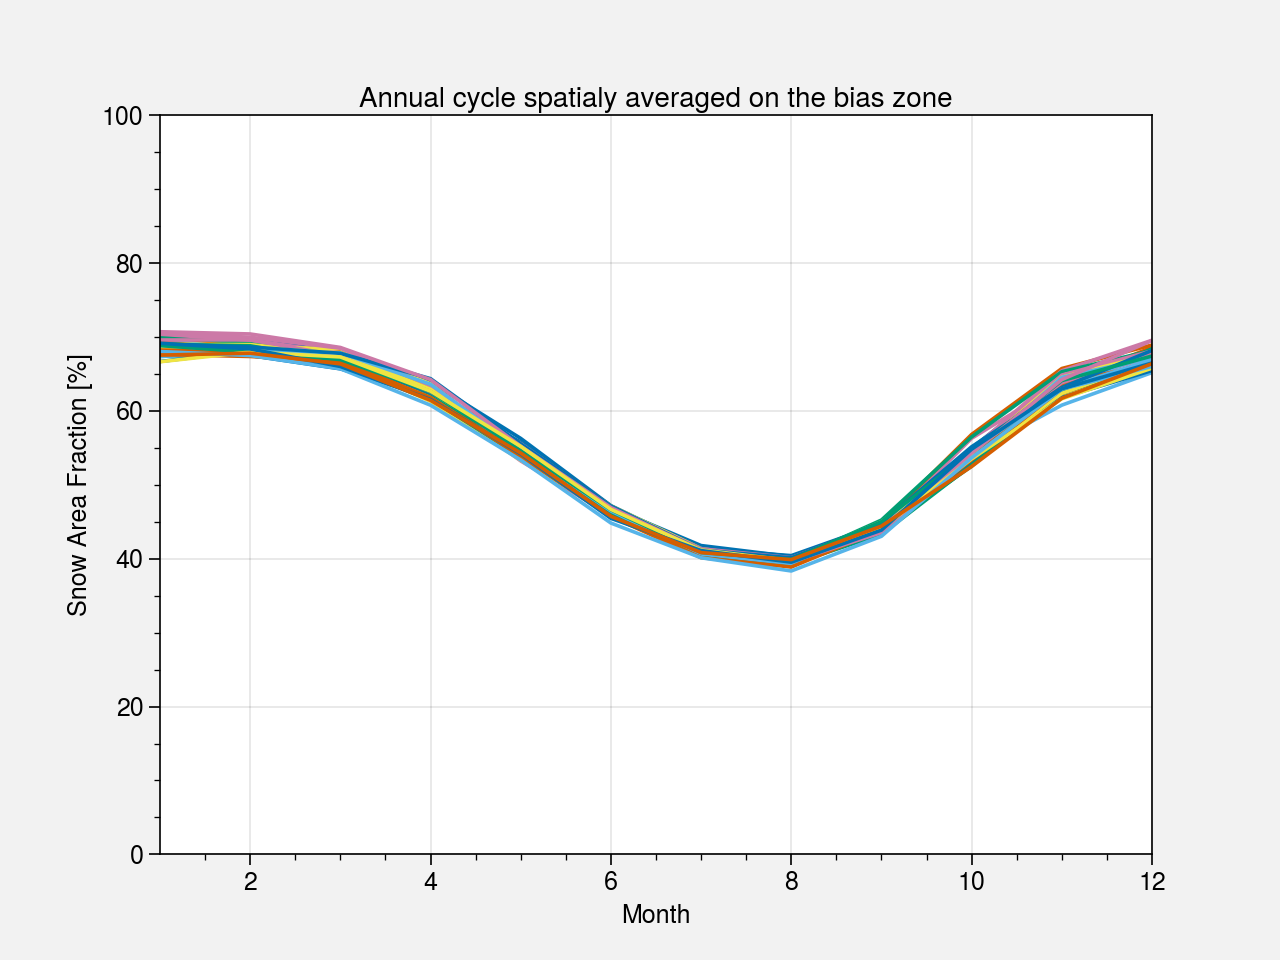

In [37]:
fig, ax = plt.subplots()

for i in ac_historical_ens.realization.values:
    ac_historical_ens[i].plot(ax=ax)

plt.title('Annual cycle spatialy averaged on the bias zone')
plt.ylim(0,100)
plt.ylabel('Snow Area Fraction [%]')
plt.xlabel('Month')
# plt.legend()